In [1]:
import polars as pl
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timezone
import glob

start_date = datetime(2023, 8, 10, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 5, 23, 59, 59).replace(tzinfo=timezone.utc)

pic_path = "../data/picarro/CFADS2343-20230810-000017Z-DataLog_User.dat"

data = {"date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": []}


def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

In [2]:
local_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/data/"
df_gas = pl.read_csv(os.path.join(local_directory, "averaged_gases.csv"))
df_old = pl.scan_parquet(os.path.join(local_directory, "old_db_renamed_measurements.parquet"))

# Picarro data

In [9]:
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"
filenames = glob.glob(picarro_path + "/*/*/*.dat")

df_list = []
for filename in filenames:
    df_list.append(pd.read_csv(filename,sep='\s+'))

df_pic_cal = pd.concat(df_list, ignore_index=True)
df_pic_cal["datetime"] = pd.to_datetime((df_pic_cal['DATE'] + ' ' + df_pic_cal['TIME']))
df_pic_cal.sort_values(by='datetime', inplace = True)


jena_bottles_true = [427.38,818.29]#,610.95]
jena_bottles_meas = []

def average_bottle(df,start_date, end_date):
    conc_list = df.loc[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]["CO2_dry"].to_list()
    uncut_avg = df.loc[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]["CO2_dry"].mean()
    print(f"Uncut average: {uncut_avg}")

    if len(conc_list) > 0:
        conc_list_cut = conc_list[int(len(conc_list)*0.3):int(len(conc_list)*0.95)]
        cut_avg = sum(conc_list_cut) / len(conc_list_cut)
        print(f"Cut average: {cut_avg}")
    
        return cut_avg
    return 0

In [20]:
jena_bottles_true = [427.38,610.95]
jena_bottles_meas = []

In [21]:
# PICARRO Bottle 1: CO2 = 427.38 ppm ± 0.01 ppm
start_date = datetime(2023, 6, 23, 8, 12, 0)
end_date = datetime(2023, 6, 23, 8, 43, 0)

jena_bottles_meas.append(average_bottle(df_pic_cal,start_date, end_date))

#427.38

Uncut average: 424.62406454449837
Cut average: 424.6187384773488


In [22]:
# PICARRO Bottle 2: CO2 = 610.95 ppm ± 0.02 ppm
start_date = datetime(2023, 6, 23, 8, 44, 0)
end_date = datetime(2023, 6, 23, 9, 20, 0)

jena_bottles_meas.append(average_bottle(df_pic_cal,start_date, end_date))

#610.95

Uncut average: 603.5070389035292
Cut average: 607.0650673613894


In [23]:
# PICARRO Bottle 3: CO2 = 818.29 ppm ± 0.03 ppm
start_date = datetime(2023, 6, 23, 9, 21, 0)
end_date = datetime(2023, 6, 23, 9, 51, 0)

#jena_bottles_meas.append(average_bottle(df_pic_cal,start_date, end_date))

In [24]:
print(jena_bottles_meas, jena_bottles_true)

[424.6187384773488, 607.0650673613894] [427.38, 610.95]


In [26]:
pic_slope, pic_intercept = two_point_calibration(jena_bottles_meas, jena_bottles_true)
print(pic_slope, pic_intercept)

607.0650673613894 * pic_slope + pic_intercept 

1.0061589132696314 0.14607153970888476


610.95

In [48]:
df_pic = pd.read_csv(pic_path,sep='\s+')
df_pic["datetime"] = pd.to_datetime((df_pic['DATE'] + ' ' + df_pic['TIME']))

pic_bias = jena_bottles_true[0] - jena_bottles_meas[0]

# correct Picarro data
#df_pic["CO2_corr"] = df_pic["CO2_dry"] + pic_slope + pic_bias 
df_pic["CO2_corr"] = df_pic["CO2_dry"] * pic_slope + pic_intercept

df_pic.head()

,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,...,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,CO2_corr
0,2023-08-10,00:00:01.301,221.000015,5304.000361,222.000015,1.691626e+09,0,963,140.011403,44.999779,...,428.014612,1.964847,1181.717128,90.158469,1084.879504,83.864144,-0.074230,-0.044651,2023-08-10 00:00:01.301,430.796788
1,2023-08-10,00:00:02.224,221.000026,5304.000618,222.000026,1.691626e+09,0,963,139.999732,44.999779,...,428.014612,1.964847,1181.717128,90.158469,1084.882126,83.864144,-0.074230,-0.044651,2023-08-10 00:00:02.224,430.796788
2,2023-08-10,00:00:02.736,221.000032,5304.000760,222.000032,1.691626e+09,0,963,139.999176,44.999779,...,427.967180,1.966582,1181.717128,90.158469,1084.882126,83.864144,-0.074230,-0.044651,2023-08-10 00:00:02.736,430.749064
3,2023-08-10,00:00:04.279,221.000050,5304.001189,222.000050,1.691626e+09,0,963,139.976430,44.999779,...,427.967180,1.966582,1181.784979,105.702980,1084.832475,76.380739,-0.074220,-0.044661,2023-08-10 00:00:04.279,430.749064
4,2023-08-10,00:00:05.203,221.000060,5304.001446,222.000060,1.691626e+09,0,963,140.004601,44.999728,...,427.967180,1.966582,1181.784979,105.702980,1084.821826,71.939360,-0.074222,-0.044661,2023-08-10 00:00:05.203,430.749064


# System data

In [49]:
def avg_meas_bottle(df, bottle_id = 0):
    
    df_temp = df.filter(pl.col("gas_bottle_id") == str(bottle_id))
    
    if len(df_temp) > 60:
        df_temp = df_temp.filter(pl.col("CO2_filtered") > 0)
        avg = df_temp["CO2_filtered"][(int(len(df_temp)*0.5)):(int(len(df_temp)*0.95))].mean()
    else:
        df_temp = df_temp.filter(pl.col("CO2_filtered") > 0)
        avg = df_temp["CO2_filtered"][(int(len(df_temp)*0.3)):(int(len(df_temp)*0.95))].mean()
        
    #sns.lineplot(data=df_temp,x='date',y="CO2_compensated")
    return avg


In [50]:
def corrected_vaisala_data(df, system, bottles):
    bottles_meas = [avg_meas_bottle(df, bottle_id = bottles[0]),avg_meas_bottle(df, bottle_id = bottles[1])]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== bottles[0])["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== bottles[1])["CO2_dry"][0]]
    
    bias400 =   bottles_true[0] - bottles_meas[0]
    bias800 =   bottles_true[1] - bottles_meas[1]
    print(f"Bias of system {system} at bottle {bottles[0]}: {bias400} and bottle {bottles[1]}: {bias800}")

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)

    df_meas = df.filter(pl.col("variant") == "measurement").filter(pl.col("system name") == f"tum-esm-midcost-raspi-{system}")
    df_meas = df_meas.filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550)
    df_meas = df_meas.sort("date").groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())
    #df_meas = df_meas.with_columns(pl.col("CO2_filtered") + bias400 * slope)
    df_meas = df_meas.with_columns(pl.col("CO2_filtered") * slope + intercept)
    
    return df_meas

def uncorrected_vaisala_data(df, system, bottles):

    df_meas = df.filter(pl.col("variant") == "measurement").filter(pl.col("system name") == f"tum-esm-midcost-raspi-{system}")
    df_meas = df_meas.filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550)
    df_meas = df_meas.sort("date").groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())
    #df_meas = df_meas.with_columns(pl.col("CO2_filtered") * slope + intercept)
    
    return df_meas

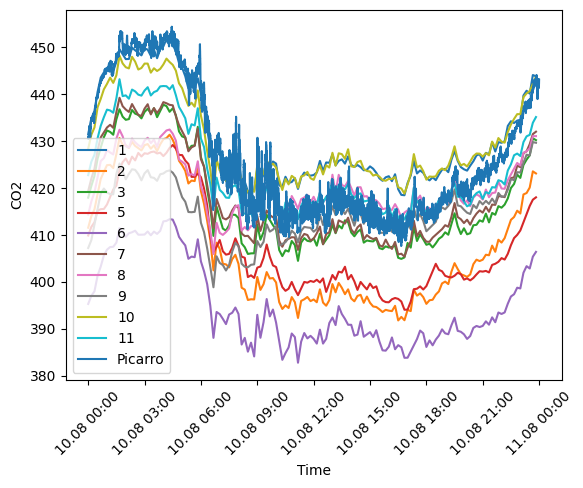

In [51]:
# uncorrected Vaisala data
sns.lineplot(data=uncorrected_vaisala_data(df, 1, [6,2]),x='date',y="CO2_filtered", label = "1")
sns.lineplot(data=uncorrected_vaisala_data(df, 2, [4,25]),x='date',y="CO2_filtered", label = "2") 
sns.lineplot(data=uncorrected_vaisala_data(df, 3, [27,14]),x='date',y="CO2_filtered", label = "3")
sns.lineplot(data=uncorrected_vaisala_data(df, 5, [22,35]),x='date',y="CO2_filtered", label = "5") 
sns.lineplot(data=uncorrected_vaisala_data(df, 6, [7,38]),x='date',y="CO2_filtered", label = "6")
sns.lineplot(data=uncorrected_vaisala_data(df, 7, [26,37]),x='date',y="CO2_filtered", label = "7") 
sns.lineplot(data=uncorrected_vaisala_data(df, 8, [30,39]),x='date',y="CO2_filtered", label = "8")
sns.lineplot(data=uncorrected_vaisala_data(df, 9, [8,33]),x='date',y="CO2_filtered", label = "9")
sns.lineplot(data=uncorrected_vaisala_data(df, 10, [36,9]),x='date',y="CO2_filtered", label = "10")
sns.lineplot(data=uncorrected_vaisala_data(df, 11, [5,34]),x='date',y="CO2_filtered", label = "11")
sns.lineplot(data=df_pic,x='datetime',y="CO2_corr",label="Picarro")

# set axes labels
plt.xlabel('Time')
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

Bias of system 5 at bottle 22: 10.16515854840975 and bottle 35: 19.083287133478166
Bias of system 6 at bottle 7: 22.228991282743493 and bottle 38: 35.74517997186865
Bias of system 7 at bottle 26: 0.05952876623013026 and bottle 37: 9.23161715845913
Bias of system 9 at bottle 8: -1.004731687245851 and bottle 33: 8.076198057076112
Bias of system 11 at bottle 5: 2.187553351911504 and bottle 34: -2.975234764088441
Bias of system 12 at bottle 19: 20.50465753164201 and bottle 24: 20.787725971005102
Bias of system 13 at bottle 23: -14.069771810393718 and bottle 1: -7.710487482576241
Bias of system 14 at bottle 18: 1.993512169222356 and bottle 31: 12.8991717282737
Bias of system 15 at bottle 20: -13.532426332993111 and bottle 15: -17.710633467074558
Bias of system 16 at bottle 3: -7.8397093283844015 and bottle 10: 2.6801149375828572
Bias of system 18 at bottle 21: 10.809698493892313 and bottle 28: 23.03393484666799
Bias of system 20 at bottle 11: 2.7985971716855715 and bottle 29: 14.23289762352

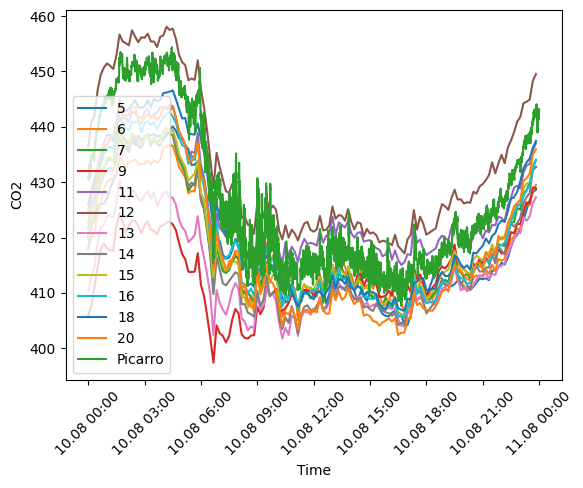

In [52]:
# corrected Vaisala data
#sns.lineplot(data=corrected_vaisala_data(df, 1, [6,2]),x='date',y="CO2_filtered", label = "1")
#sns.lineplot(data=corrected_vaisala_data(df, 2, [4,25]),x='date',y="CO2_filtered", label = "2") 
#sns.lineplot(data=corrected_vaisala_data(df, 3, [27,14]),x='date',y="CO2_filtered", label = "3")
#sns.lineplot(data=corrected_vaisala_data(df, 4, [16,40]),x='date',y="CO2_filtered", label = "4")
sns.lineplot(data=corrected_vaisala_data(df, 5, [22,35]),x='date',y="CO2_filtered", label = "5") 
sns.lineplot(data=corrected_vaisala_data(df, 6, [7,38]),x='date',y="CO2_filtered", label = "6")
sns.lineplot(data=corrected_vaisala_data(df, 7, [26,37]),x='date',y="CO2_filtered", label = "7") 
#sns.lineplot(data=corrected_vaisala_data(df, 8, [30,39]),x='date',y="CO2_filtered", label = "8")
sns.lineplot(data=corrected_vaisala_data(df, 9, [8,33]),x='date',y="CO2_filtered", label = "9")
#sns.lineplot(data=corrected_vaisala_data(df, 10, [36,9]),x='date',y="CO2_filtered", label = "10")
sns.lineplot(data=corrected_vaisala_data(df, 11, [5,34]),x='date',y="CO2_filtered", label = "11")
sns.lineplot(data=corrected_vaisala_data(df, 12, [19,24]),x='date',y="CO2_filtered", label = "12")
sns.lineplot(data=corrected_vaisala_data(df, 13, [23,1]),x='date',y="CO2_filtered", label = "13")
sns.lineplot(data=corrected_vaisala_data(df, 14, [18,31]),x='date',y="CO2_filtered", label = "14")
sns.lineplot(data=corrected_vaisala_data(df, 15, [20,15]),x='date',y="CO2_filtered", label = "15")
sns.lineplot(data=corrected_vaisala_data(df, 16, [3,10]),x='date',y="CO2_filtered", label = "16")
sns.lineplot(data=corrected_vaisala_data(df, 18, [21,28]),x='date',y="CO2_filtered", label = "18")
sns.lineplot(data=corrected_vaisala_data(df, 20, [11,29]),x='date',y="CO2_filtered", label = "20")
sns.lineplot(data=df_pic,x='datetime',y="CO2_corr",label="Picarro")

# set axes labels
plt.xlabel('Time')
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

In [53]:
df.filter(pl.col("variant") == "calibration").filter(pl.col("system name") == f"tum-esm-midcost-raspi-9").groupby("gas_bottle_id").head()

gas_bottle_id,date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature
str,"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""8""",2023-08-10 18:21:39.730 UTC,"""tum-esm-midcos…","""calibration""",540.7,598.2,598.2,7.36,3.25,956.41,34.22,33.73,30.0
"""8""",2023-08-10 18:21:49.740 UTC,"""tum-esm-midcos…","""calibration""",429.7,472.3,472.3,1.77,0.28,956.52,34.21,33.75,29.9
"""8""",2023-08-10 18:21:59.740 UTC,"""tum-esm-midcos…","""calibration""",385.6,423.6,423.6,1.06,0.0,956.59,34.27,33.8,29.9
"""8""",2023-08-10 18:22:09.750 UTC,"""tum-esm-midcos…","""calibration""",384.1,421.9,421.9,0.85,0.0,956.15,34.3,33.83,29.9
"""8""",2023-08-10 18:22:19.760 UTC,"""tum-esm-midcos…","""calibration""",382.2,420.1,420.1,0.75,0.0,956.03,34.36,33.88,29.9
"""33""",2023-08-10 18:01:28.810 UTC,"""tum-esm-midcos…","""calibration""",370.9,415.9,415.9,27.02,24.74,897.08,29.56,29.07,30.2
"""33""",2023-08-10 18:01:38.820 UTC,"""tum-esm-midcos…","""calibration""",562.4,676.2,676.2,10.37,11.38,955.97,29.57,29.05,30.2
"""33""",2023-08-10 18:01:48.840 UTC,"""tum-esm-midcos…","""calibration""",670.5,741.3,741.3,3.48,6.18,955.34,29.55,29.04,30.2
"""33""",2023-08-10 18:01:58.840 UTC,"""tum-esm-midcos…","""calibration""",709.8,786.3,786.3,2.34,4.42,954.47,29.53,29.03,30.2


# Get counts for calibration measurements per station per bottle per day

In [54]:
df_test = df.select(["date", "system name", "gas_bottle_id"]).to_pandas().groupby([pd.Grouper(key="date", freq="1D"), "gas_bottle_id"]).count()

In [55]:
df_test["system name"]

date                       gas_bottle_id
2023-08-10 00:00:00+00:00  1                121
                           10               121
                           11                61
                           15               121
                           16                61
                           18                58
                           19                61
                           20                61
                           21                61
                           22                61
                           23                61
                           24               121
                           26                61
                           28               121
                           29               121
                           3                 61
                           31               121
                           33               121
                           34               121
                           35               121

In [56]:
df_test.loc[[df_test["gas_bottle_id"] == 14]]

KeyError: 'gas_bottle_id'